In [1]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [2]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('benroshan/factors-affecting-campus-placement', path="/content/drive/MyDrive/ML/campus-placement", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/benroshan/factors-affecting-campus-placement


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML/campus-placement/Placement_Data_Full_Class.csv')

In [5]:
# Display the first few rows and basic information about the dataset
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


In [7]:
# Separate categorical and numerical columns
catvars = list(df.select_dtypes(include=['object']).columns)
numvars = list(df.select_dtypes(include=['int64', 'float64']).columns)
print("Categorical variables:", catvars)
print("Numerical variables:", numvars)

Categorical variables: ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation', 'status']
Numerical variables: ['sl_no', 'ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'salary']


In [8]:
# Check for missing values
print(df.isnull().sum())

sl_no              0
gender             0
ssc_p              0
ssc_b              0
hsc_p              0
hsc_b              0
hsc_s              0
degree_p           0
degree_t           0
workex             0
etest_p            0
specialisation     0
mba_p              0
status             0
salary            67
dtype: int64


In [9]:
# Handling Null values
df['salary_mean'] = df['salary'].fillna(df['salary'].mean())
df['salary_median'] = df['salary'].fillna(df['salary'].median())
df['salary_mode'] = df['salary'].fillna(df['salary'].mode()[0])

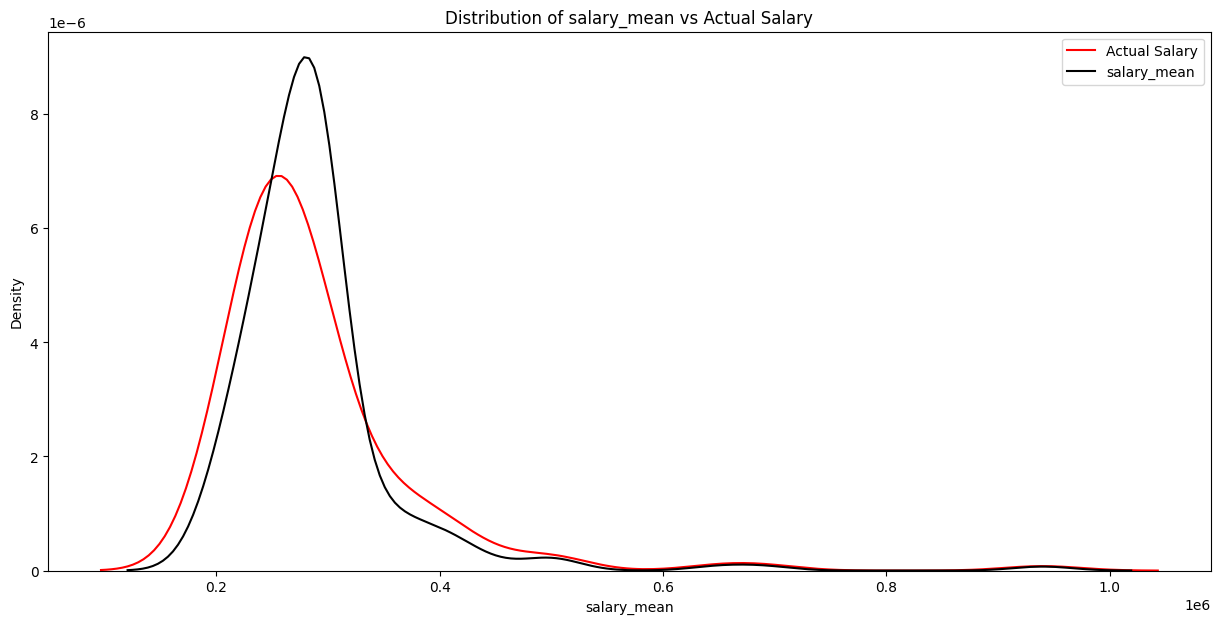

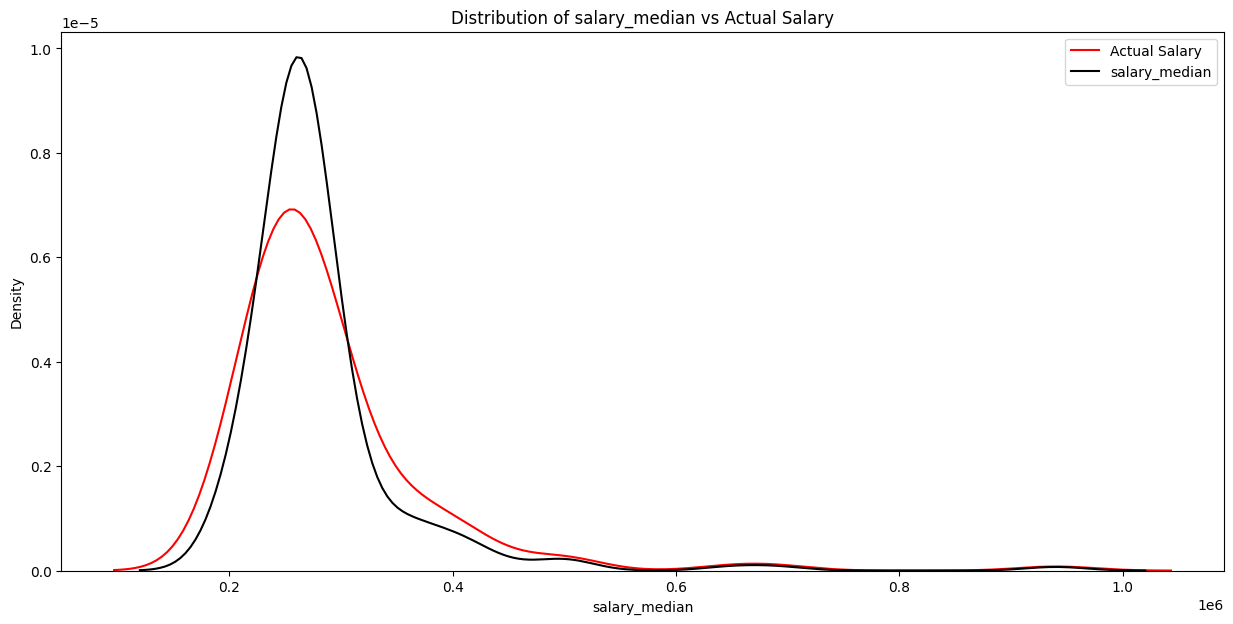

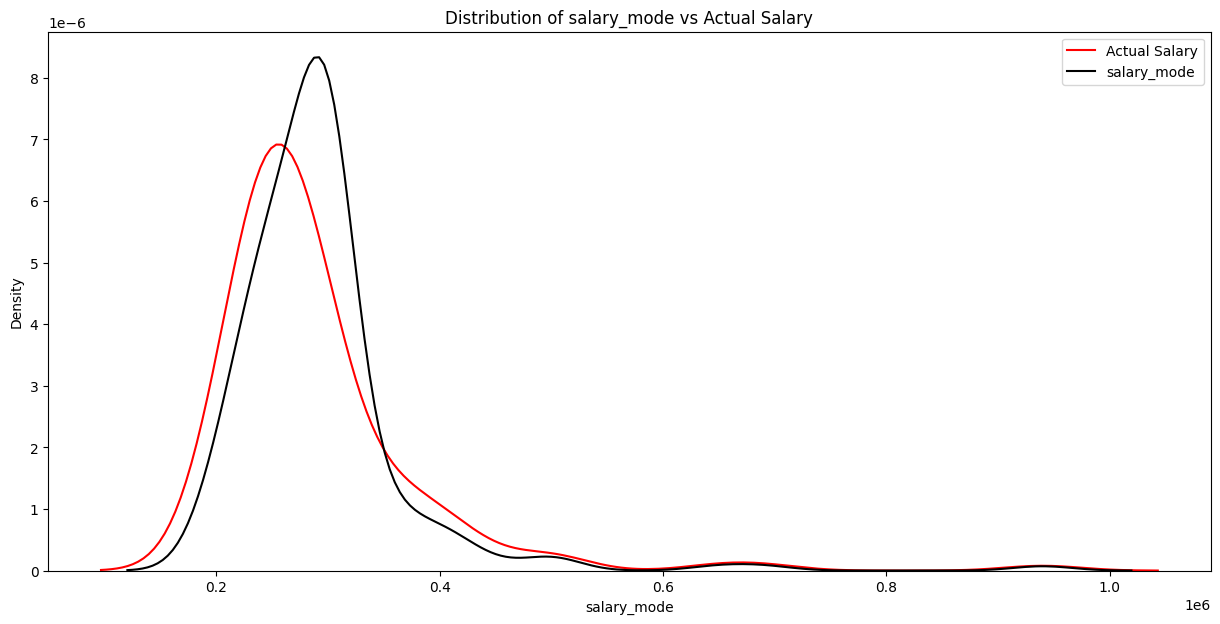

In [10]:
# Plot distribution of salary imputations
def plotdistplot(col):
    plt.figure(figsize=(15,7))
    sns.distplot(df['salary'], kde=True, hist=False, label='Actual Salary', color='red')
    sns.distplot(df[col], kde=True, hist=False, label=col, color='black')
    plt.legend()
    plt.title(f'Distribution of {col} vs Actual Salary')
    plt.show()

sallist = ['salary_mean', 'salary_median', 'salary_mode']
for sal in sallist:
    plotdistplot(sal)

In [11]:
# Fill salary with mean
df['salary'] = df['salary'].fillna(df['salary'].mean())

In [12]:
# Drop temporary columns
df = df.drop(columns=['salary_mean', 'salary_median', 'salary_mode'], axis=1)

Count Plot for feature gender is shown ↓


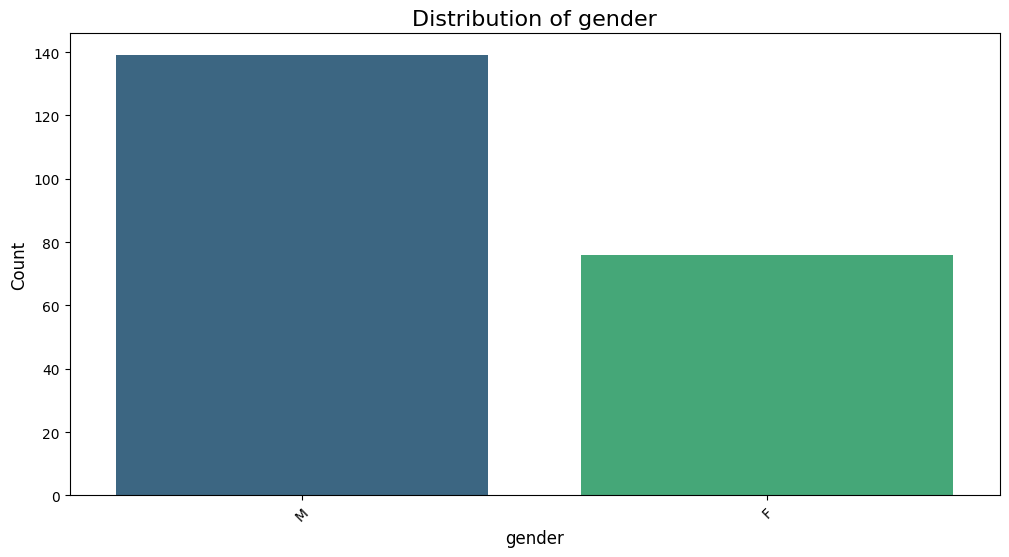

Count Plot for feature ssc_b is shown ↓


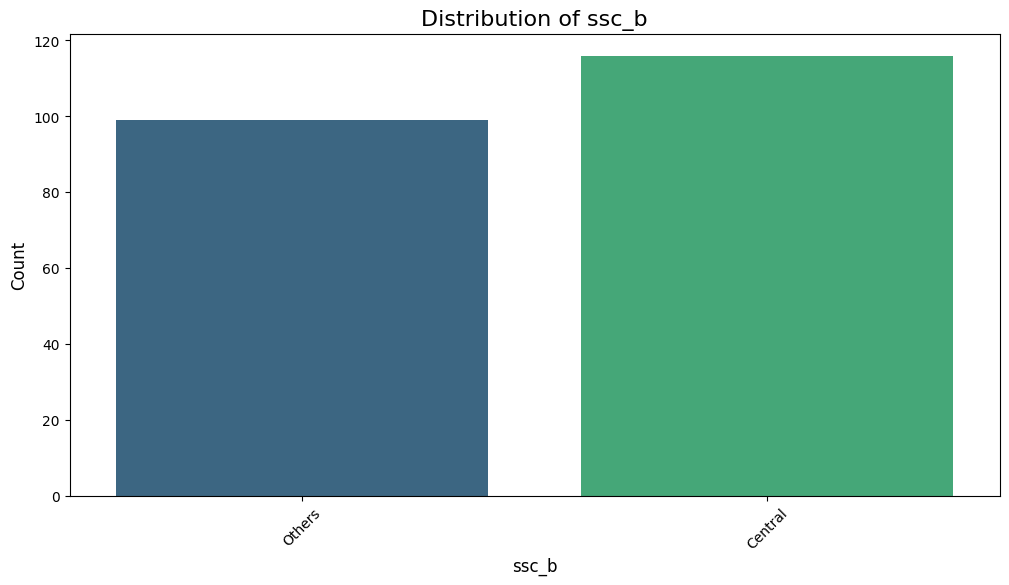

Count Plot for feature hsc_b is shown ↓


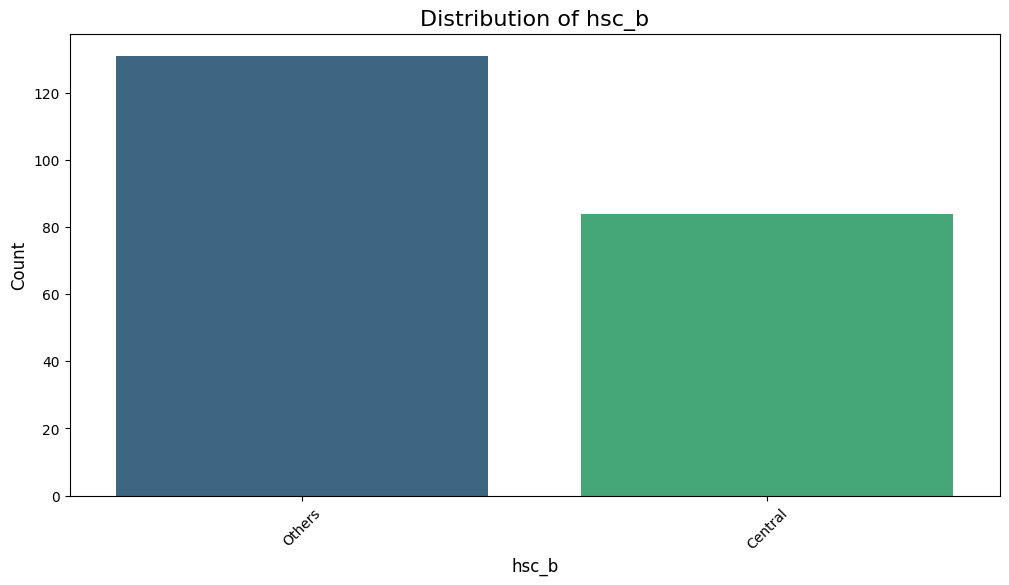

Count Plot for feature hsc_s is shown ↓


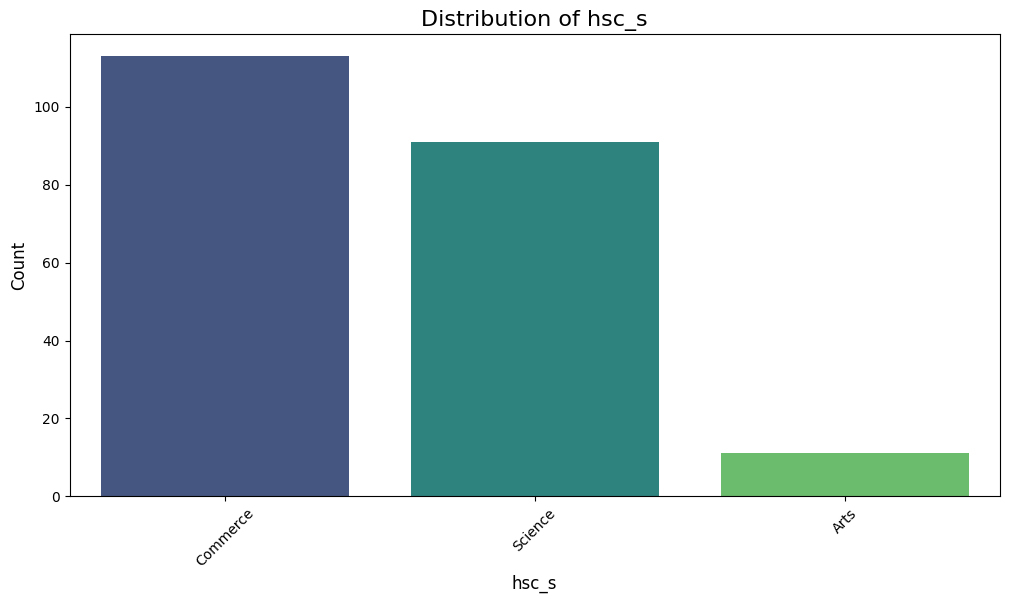

Count Plot for feature degree_t is shown ↓


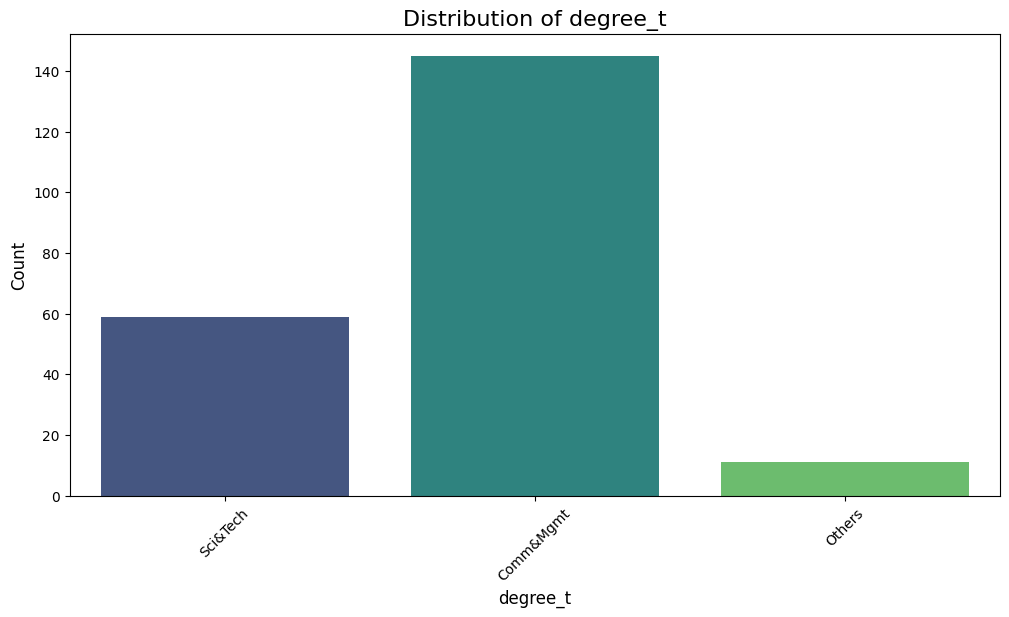

Count Plot for feature workex is shown ↓


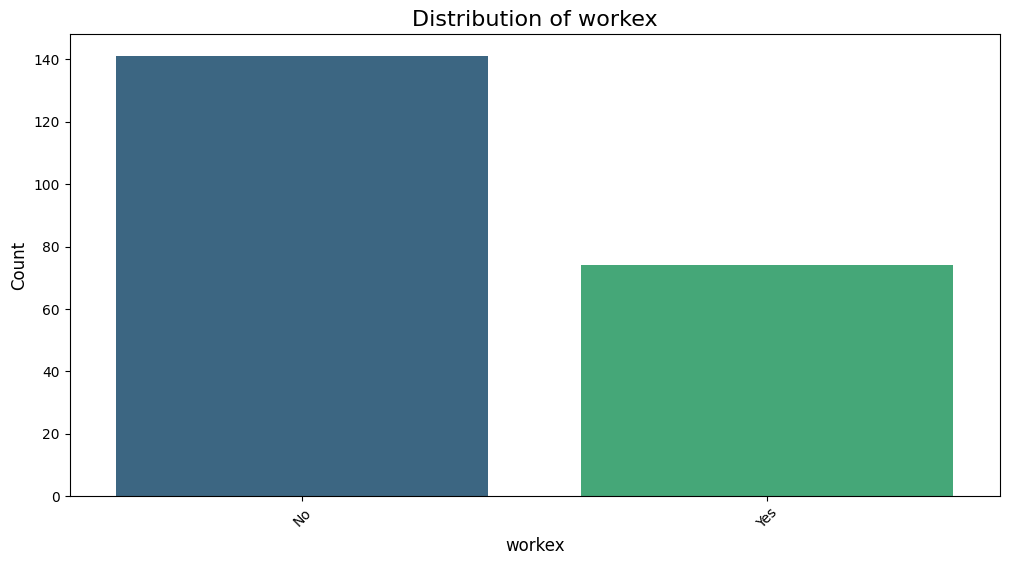

Count Plot for feature specialisation is shown ↓


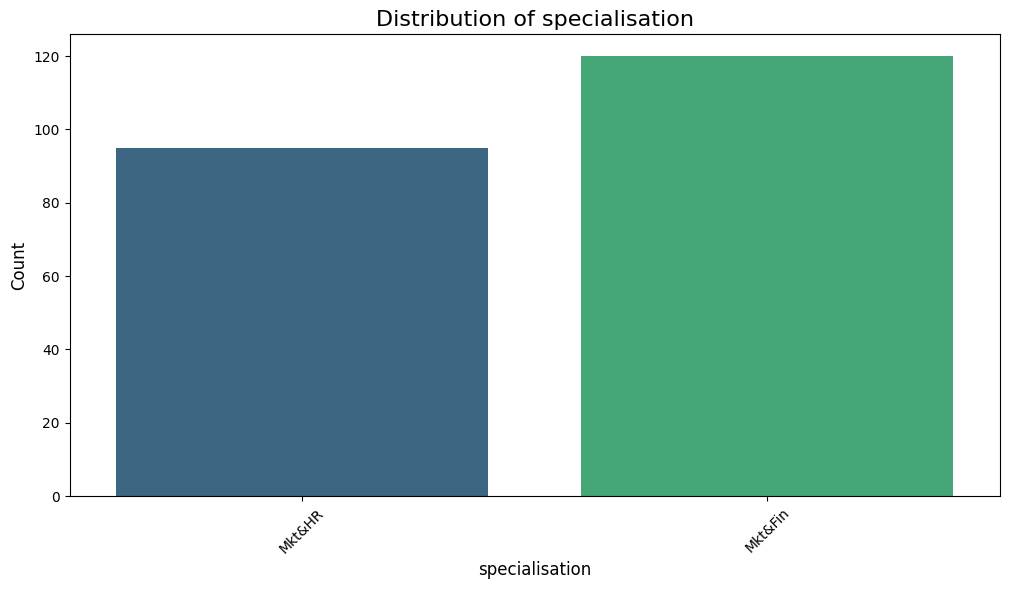

Count Plot for feature status is shown ↓


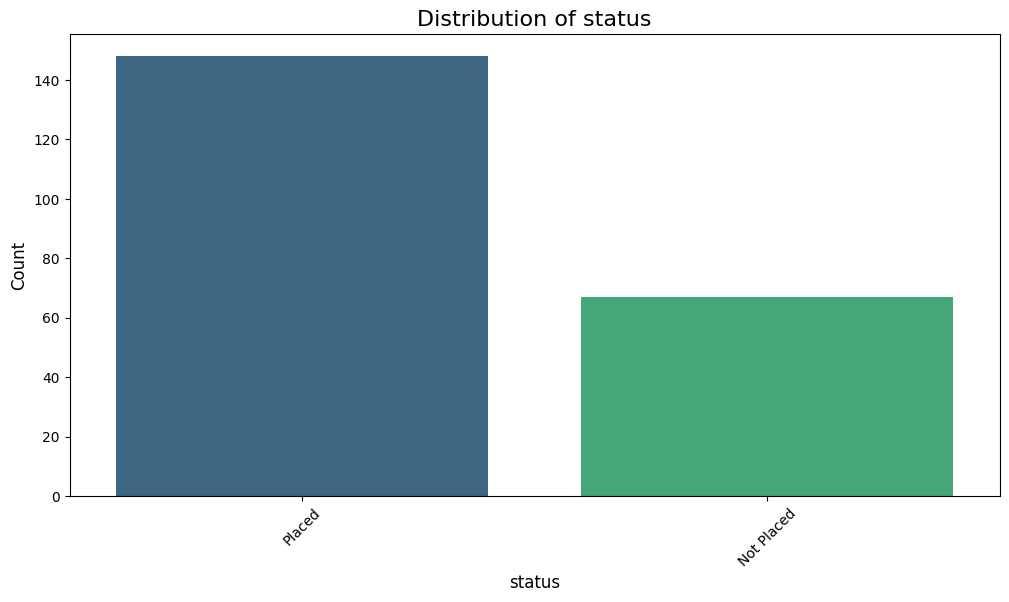

In [13]:
# EDA
def getcountplot(col):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

for col in catvars:
    print(f'Count Plot for feature {col} is shown ↓')
    getcountplot(col)
    print('='*130)

In [14]:
# Create getfinaldict
getfinaldict = {}
for col in catvars:
    getfinaldict[col] = dict(df[col].value_counts())

getfinaldict

{'gender': {'M': 139, 'F': 76},
 'ssc_b': {'Central': 116, 'Others': 99},
 'hsc_b': {'Others': 131, 'Central': 84},
 'hsc_s': {'Commerce': 113, 'Science': 91, 'Arts': 11},
 'degree_t': {'Comm&Mgmt': 145, 'Sci&Tech': 59, 'Others': 11},
 'workex': {'No': 141, 'Yes': 74},
 'specialisation': {'Mkt&Fin': 120, 'Mkt&HR': 95},
 'status': {'Placed': 148, 'Not Placed': 67}}

In [15]:
# Top science students placed
top_science = df[(df['degree_t']=='Sci&Tech') & (df['status']=='Placed')].sort_values(by='salary', ascending=False).reset_index().head(5)
print("Top 5 placed science students:")
top_science

Top 5 placed science students:


,index,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,150,151,M,71.00,Central,58.66,Central,Science,58.00,Sci&Tech,Yes,56.0,Mkt&Fin,61.30,Placed,690000.0
1,77,78,M,64.00,Others,80.00,Others,Science,65.00,Sci&Tech,Yes,69.0,Mkt&Fin,57.65,Placed,500000.0
2,163,164,M,63.00,Others,67.00,Others,Science,64.00,Sci&Tech,No,75.0,Mkt&Fin,66.46,Placed,500000.0
3,174,175,M,73.24,Others,50.83,Others,Science,64.27,Sci&Tech,Yes,64.0,Mkt&Fin,66.23,Placed,500000.0
4,53,54,M,80.00,Others,70.00,Others,Science,72.00,Sci&Tech,No,87.0,Mkt&HR,71.04,Placed,450000.0


In [16]:
# Top Comm&Mgmt students placed
top_comm_mgmt = df[(df['degree_t']=='Comm&Mgmt') & (df['status']=='Placed')].sort_values(by='salary', ascending=False).reset_index().head(5)
print("Top 5 placed Comm&Mgmt students:")
top_comm_mgmt

Top 5 placed Comm&Mgmt students:


,index,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,119,120,M,60.8,Central,68.4,Central,Commerce,64.6,Comm&Mgmt,Yes,82.66,Mkt&Fin,64.34,Placed,940000.0
1,177,178,F,73.0,Central,97.0,Others,Commerce,79.0,Comm&Mgmt,Yes,89.00,Mkt&Fin,70.81,Placed,650000.0
2,4,5,M,85.8,Central,73.6,Central,Commerce,73.3,Comm&Mgmt,No,96.80,Mkt&Fin,55.50,Placed,425000.0
3,95,96,M,73.0,Central,78.0,Others,Commerce,65.0,Comm&Mgmt,Yes,95.46,Mkt&Fin,62.16,Placed,420000.0
4,210,211,M,80.6,Others,82.0,Others,Commerce,77.6,Comm&Mgmt,No,91.00,Mkt&Fin,74.49,Placed,400000.0


In [17]:
# Max and min salary
max_min_salary = df[(df['salary']==df['salary'].max()) | (df['salary']==df['salary'].min())]
print("Students with maximum and minimum salary:")
max_min_salary

Students with maximum and minimum salary:


,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.50,Mkt&Fin,66.28,Placed,200000.0
15,16,F,65.00,Central,75.00,Central,Commerce,69.00,Comm&Mgmt,Yes,72.00,Mkt&Fin,64.66,Placed,200000.0
44,45,F,77.00,Others,73.00,Others,Commerce,81.00,Comm&Mgmt,Yes,89.00,Mkt&Fin,69.70,Placed,200000.0
50,51,F,75.20,Central,73.20,Central,Science,68.40,Comm&Mgmt,No,65.00,Mkt&HR,62.98,Placed,200000.0
107,108,M,82.00,Others,90.00,Others,Commerce,83.00,Comm&Mgmt,No,80.00,Mkt&HR,73.52,Placed,200000.0
119,120,M,60.80,Central,68.40,Central,Commerce,64.60,Comm&Mgmt,Yes,82.66,Mkt&Fin,64.34,Placed,940000.0
135,136,F,72.00,Central,56.00,Others,Science,69.00,Comm&Mgmt,No,55.60,Mkt&HR,65.63,Placed,200000.0


In [18]:
# Students with salary more than avg salary in science dept
above_avg_science = df[(df['degree_t']=='Sci&Tech') & (df['salary'] > df['salary'].mean())].sort_values(by='salary', ascending=False).reset_index()
print("Science students with above average salary:")
above_avg_science

Science students with above average salary:


,index,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,150,151,M,71.00,Central,58.66,Central,Science,58.00,Sci&Tech,Yes,56.00,Mkt&Fin,61.30,Placed,690000.0
1,174,175,M,73.24,Others,50.83,Others,Science,64.27,Sci&Tech,Yes,64.00,Mkt&Fin,66.23,Placed,500000.0
2,77,78,M,64.00,Others,80.00,Others,Science,65.00,Sci&Tech,Yes,69.00,Mkt&Fin,57.65,Placed,500000.0
3,163,164,M,63.00,Others,67.00,Others,Science,64.00,Sci&Tech,No,75.00,Mkt&Fin,66.46,Placed,500000.0
4,53,54,M,80.00,Others,70.00,Others,Science,72.00,Sci&Tech,No,87.00,Mkt&HR,71.04,Placed,450000.0
5,39,40,M,81.00,Others,68.00,Others,Science,64.00,Sci&Tech,No,93.00,Mkt&Fin,62.56,Placed,411000.0
6,145,146,M,89.40,Others,65.66,Others,Science,71.25,Sci&Tech,No,72.00,Mkt&HR,63.23,Placed,400000.0
7,128,129,M,80.40,Central,73.40,Central,Science,77.72,Sci&Tech,Yes,81.20,Mkt&HR,76.26,Placed,400000.0
8,22,23,F,69.80,Others,60.80,Others,Science,72.23,Sci&Tech,No,55.53,Mkt&HR,68.81,Placed,360000.0
9,24,25,M,76.50,Others,97.70,Others,Science,78.86,Sci&Tech,No,97.40,Mkt&Fin,74.01,Placed,360000.0


In [19]:
# Students with salary more than avg salary in Comm&Mgmt dept
above_avg_comm_mgmt = df[(df['degree_t']=='Comm&Mgmt') & (df['salary'] > df['salary'].mean())].sort_values(by='salary', ascending=False).reset_index()
print("Comm&Mgmt students with above average salary:")
above_avg_comm_mgmt

Comm&Mgmt students with above average salary:


,index,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,119,120,M,60.80,Central,68.40,Central,Commerce,64.60,Comm&Mgmt,Yes,82.66,Mkt&Fin,64.34,Placed,940000.0
1,177,178,F,73.00,Central,97.00,Others,Commerce,79.00,Comm&Mgmt,Yes,89.00,Mkt&Fin,70.81,Placed,650000.0
2,4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.80,Mkt&Fin,55.50,Placed,425000.0
3,95,96,M,73.00,Central,78.00,Others,Commerce,65.00,Comm&Mgmt,Yes,95.46,Mkt&Fin,62.16,Placed,420000.0
4,85,86,F,83.84,Others,89.83,Others,Commerce,77.20,Comm&Mgmt,Yes,78.74,Mkt&Fin,76.18,Placed,400000.0
5,210,211,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.00,Mkt&Fin,74.49,Placed,400000.0
6,21,22,F,79.00,Others,76.00,Others,Commerce,85.00,Comm&Mgmt,No,95.00,Mkt&Fin,69.06,Placed,393000.0
7,101,102,M,63.00,Central,72.00,Central,Commerce,68.00,Comm&Mgmt,No,78.00,Mkt&HR,60.44,Placed,380000.0
8,104,105,M,69.00,Central,63.00,Others,Science,65.00,Comm&Mgmt,Yes,55.00,Mkt&HR,58.23,Placed,360000.0
9,57,58,M,68.00,Central,76.00,Central,Commerce,74.00,Comm&Mgmt,No,80.00,Mkt&Fin,63.59,Placed,360000.0


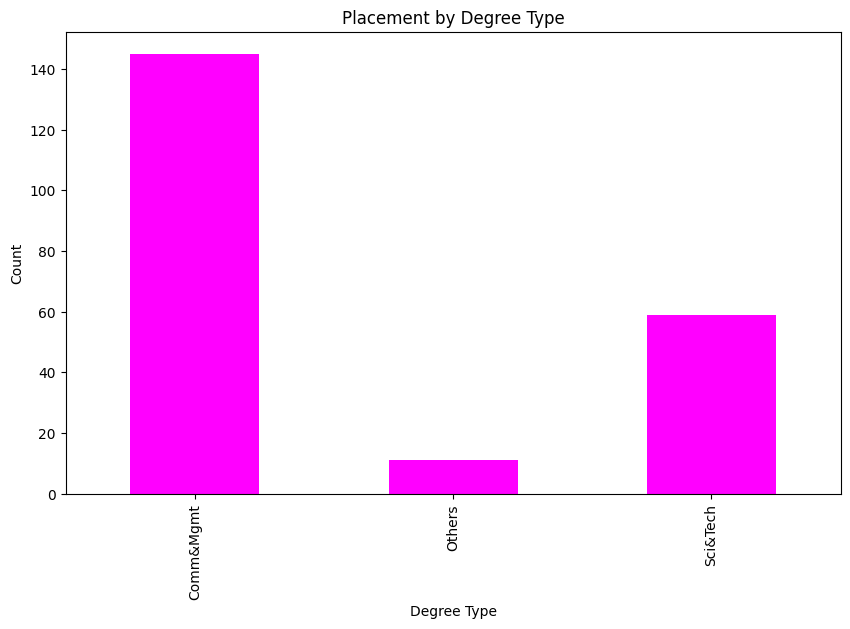

In [20]:
# Placement by degree type
plt.figure(figsize=(10, 6))
df.groupby(['degree_t'])['status'].count().plot(kind='bar', color='magenta')
plt.title('Placement by Degree Type')
plt.xlabel('Degree Type')
plt.ylabel('Count')
plt.show()

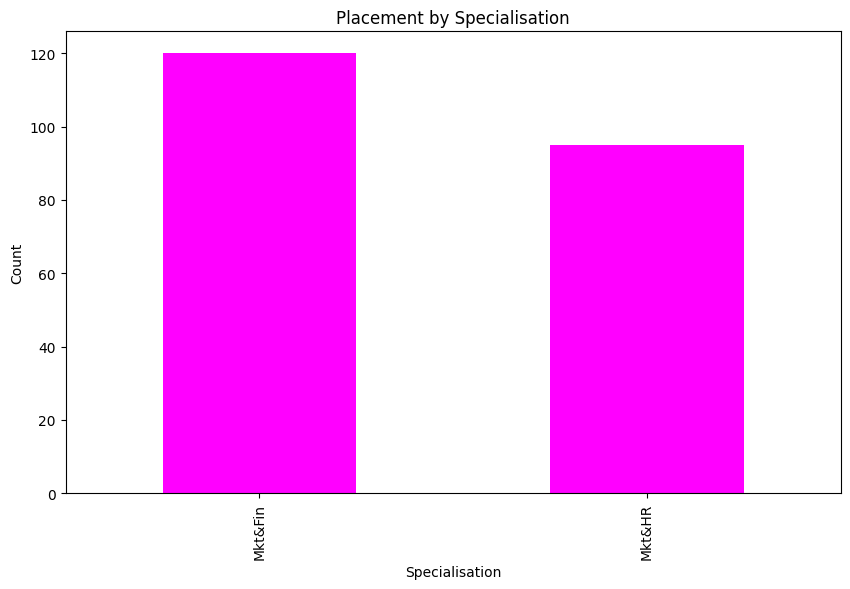

In [21]:
# Placement by specialisation
plt.figure(figsize=(10, 6))
df.groupby(['specialisation'])['status'].count().plot(kind='bar', color='magenta')
plt.title('Placement by Specialisation')
plt.xlabel('Specialisation')
plt.ylabel('Count')
plt.show()

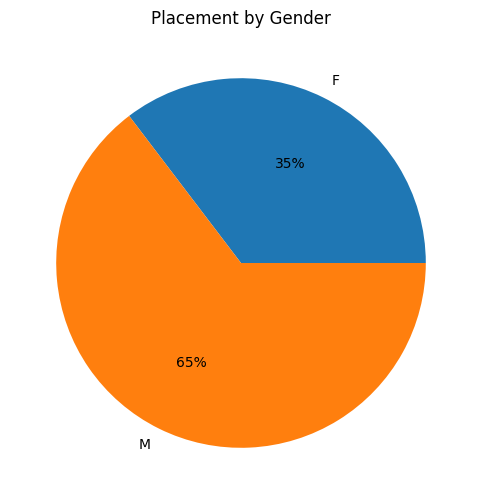

In [22]:
# Placement by gender
plt.figure(figsize=(10, 6))
df.groupby(['gender'])['status'].count().plot(kind='pie', autopct='%1.0f%%')
plt.title('Placement by Gender')
plt.ylabel('')
plt.show()

In [23]:
# Max female salary
max_female_salary = df[df['gender']=='F'][df['salary']==df[df['gender']=='F']['salary'].max()]
print("Female student with maximum salary:")
max_female_salary

Female student with maximum salary:


,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
177,178,F,73.0,Central,97.0,Others,Commerce,79.0,Comm&Mgmt,Yes,89.0,Mkt&Fin,70.81,Placed,650000.0


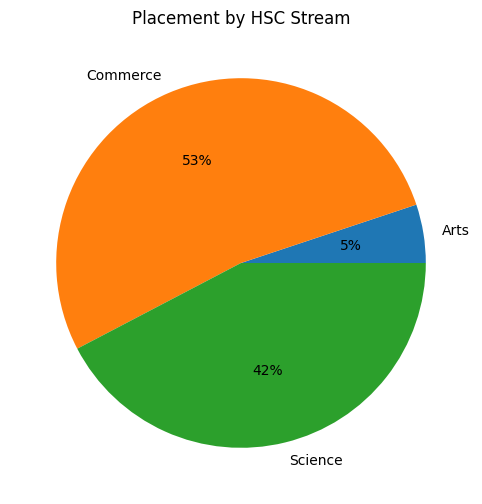

In [24]:
# Placement by hsc_s
plt.figure(figsize=(10, 6))
df.groupby(['hsc_s'])['status'].count().plot(kind='pie', autopct='%1.0f%%')
plt.title('Placement by HSC Stream')
plt.ylabel('')
plt.show()

In [25]:
# Label Encoding
def labelencode(le, col):
    df[col] = le.fit_transform(df[col])

getmappings = {}
le = LabelEncoder()
for col in list(getfinaldict.keys()):
    labelencode(le, col)
    getmappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

getmappings

{'gender': {'F': 0, 'M': 1},
 'ssc_b': {'Central': 0, 'Others': 1},
 'hsc_b': {'Central': 0, 'Others': 1},
 'hsc_s': {'Arts': 0, 'Commerce': 1, 'Science': 2},
 'degree_t': {'Comm&Mgmt': 0, 'Others': 1, 'Sci&Tech': 2},
 'workex': {'No': 0, 'Yes': 1},
 'specialisation': {'Mkt&Fin': 0, 'Mkt&HR': 1},
 'status': {'Not Placed': 0, 'Placed': 1}}

In [24]:
# Visualizing data with new label encoding
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,1,67.00,1,91.00,1,1,58.00,2,0,55.0,1,58.80,1,270000.000000
1,2,1,79.33,0,78.33,1,2,77.48,2,1,86.5,0,66.28,1,200000.000000
2,3,1,65.00,0,68.00,0,0,64.00,0,0,75.0,0,57.80,1,250000.000000
3,4,1,56.00,0,52.00,0,2,52.00,2,0,66.0,1,59.43,0,288655.405405
4,5,1,85.80,0,73.60,0,1,73.30,0,0,96.8,0,55.50,1,425000.000000


In [25]:
# Remove unwanted columns
df = df.drop(['sl_no'], axis=1)

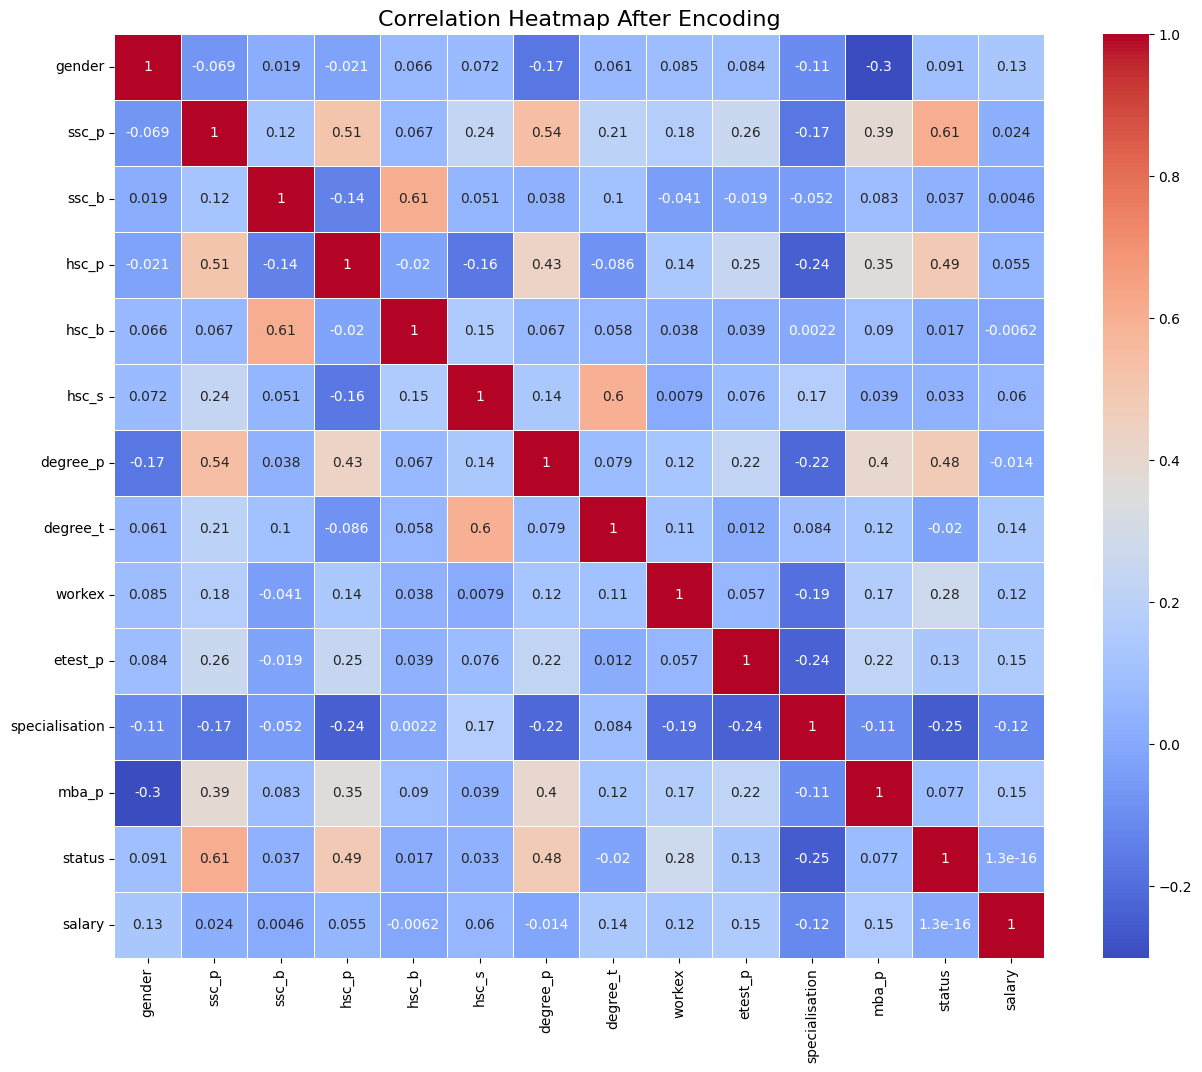

In [26]:
# Correlation heatmap after encoding
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap After Encoding', fontsize=16)
plt.show()

In [38]:
# Prepare features and target for feature selection
data = df.copy()
X = data.drop(['status', 'salary'], axis=1)
y = data['status']

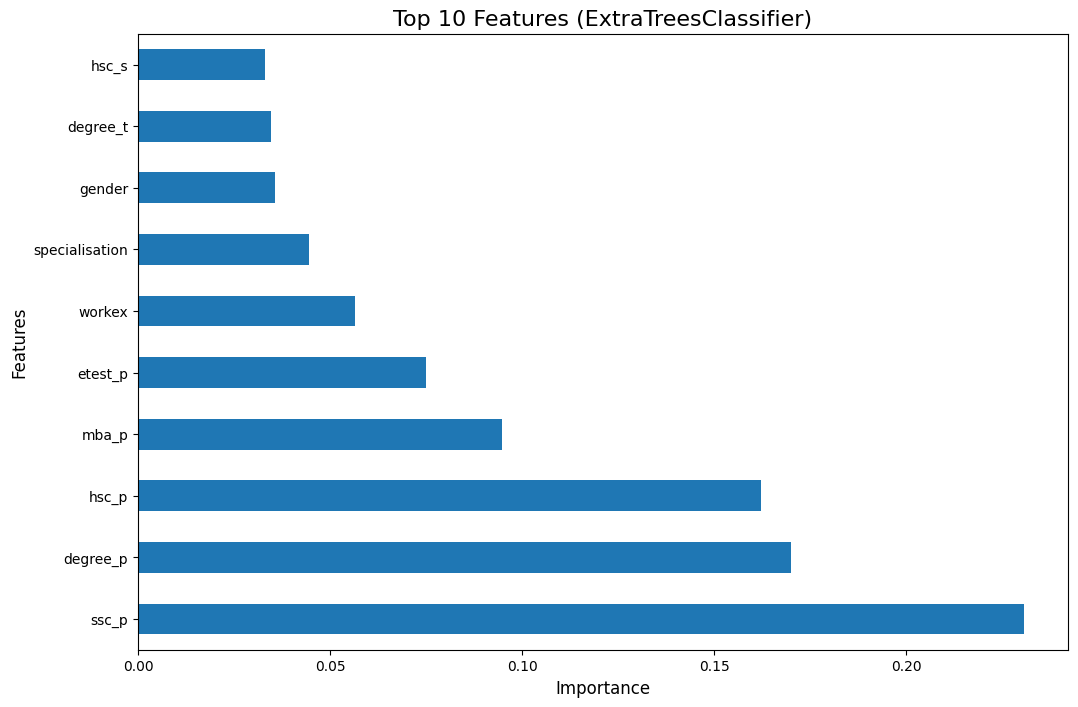

In [45]:
# ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(X, y)

featbar = pd.Series(etc.feature_importances_, index=X.columns)
plt.figure(figsize=(12, 8))
featbar.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features (ExtraTreesClassifier)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

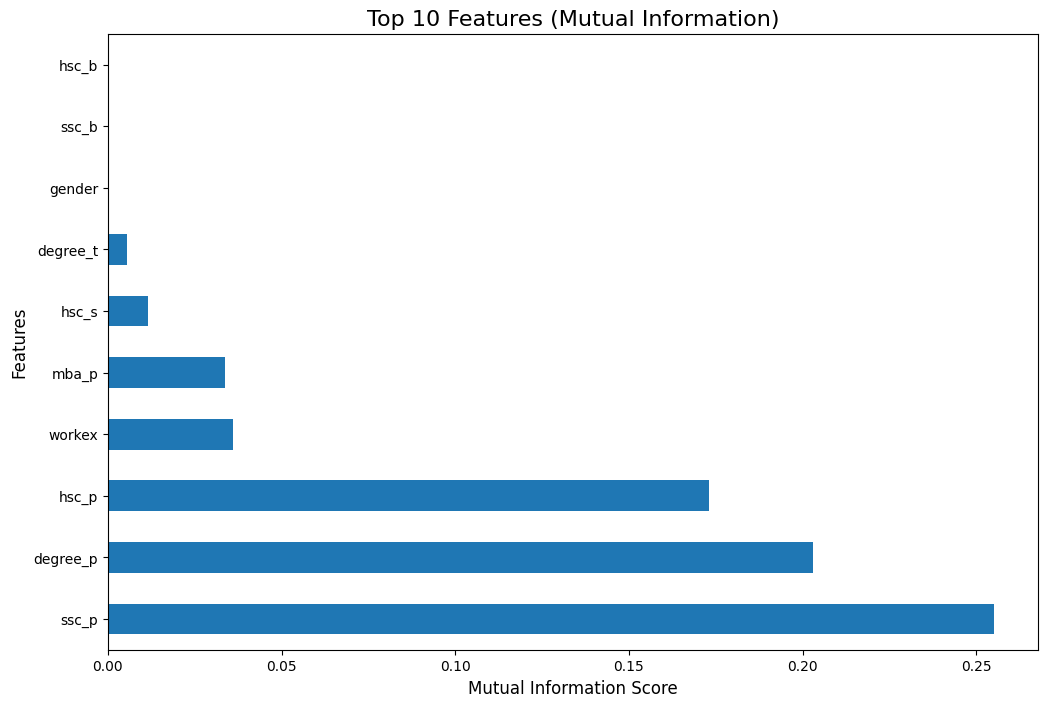

In [53]:
# Mutual Information Classification
mc = mutual_info_classif(X, y)
ax = pd.Series(mc, index=X.columns)
plt.figure(figsize=(12, 8))
ax.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features (Mutual Information)', fontsize=16)
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

In [54]:
# Select common top features
featcol = list(featbar.nlargest(10).index)
mutclasif = list(ax.nlargest(10).index)
commoncols = list(set(featcol).intersection(set(mutclasif)))
print("Common top features:", commoncols)

Common top features: ['mba_p', 'degree_p', 'workex', 'hsc_s', 'degree_t', 'hsc_p', 'ssc_p', 'gender']


In [55]:
# Use selected features for modeling
X = df[commoncols]
y = df['status']

In [56]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Define models and parameters for GridSearchCV
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    }
}

In [58]:
# Perform GridSearchCV for each model
results = []
for model_name, mp in models.items():
    print(f"Performing GridSearchCV for {model_name}...")
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, verbose=1)
    clf.fit(X_train, y_train)
    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    print(f"Completed GridSearchCV for {model_name}")

Performing GridSearchCV for RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Completed GridSearchCV for RandomForest
Performing GridSearchCV for LogisticRegression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Completed GridSearchCV for LogisticRegression
Performing GridSearchCV for DecisionTree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Completed GridSearchCV for DecisionTree
Performing GridSearchCV for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Completed GridSearchCV for SVM


In [59]:
# Display GridSearchCV results
results_df = pd.DataFrame(results)
print("\nGridSearchCV Results:")
results_df


GridSearchCV Results:


,model,best_score,best_params
0,RandomForest,0.872437,"{'max_depth': None, 'min_samples_leaf': 2, 'mi..."
1,LogisticRegression,0.860672,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin..."
2,DecisionTree,0.779160,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
3,SVM,0.860336,"{'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}"


In [60]:
# Select the best model (highest score)
best_model = results_df.loc[results_df['best_score'].idxmax()]
print(f"Best model: {best_model['model']}")
print(f"Best score: {best_model['best_score']}")
print(f"Best parameters: {best_model['best_params']}")

Best model: RandomForest
Best score: 0.8724369747899161
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [61]:
# Train the best model on the entire dataset
best_clf = models[best_model['model']]['model'].set_params(**best_model['best_params'])
best_clf.fit(X, y)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42)

In [62]:
# Make predictions
y_pred = best_clf.predict(X_test)

In [63]:
# Calculate and display metrics
print("\nModel Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance on Test Set:
Accuracy: 0.9534883720930233

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.97      0.97      0.97        31

    accuracy                           0.95        43
   macro avg       0.94      0.94      0.94        43
weighted avg       0.95      0.95      0.95        43



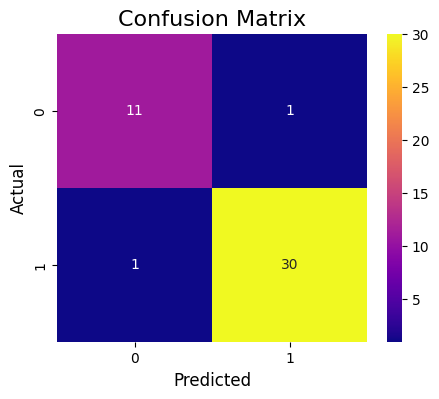

In [64]:
# Create a confusion matrix heatmap
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma')
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

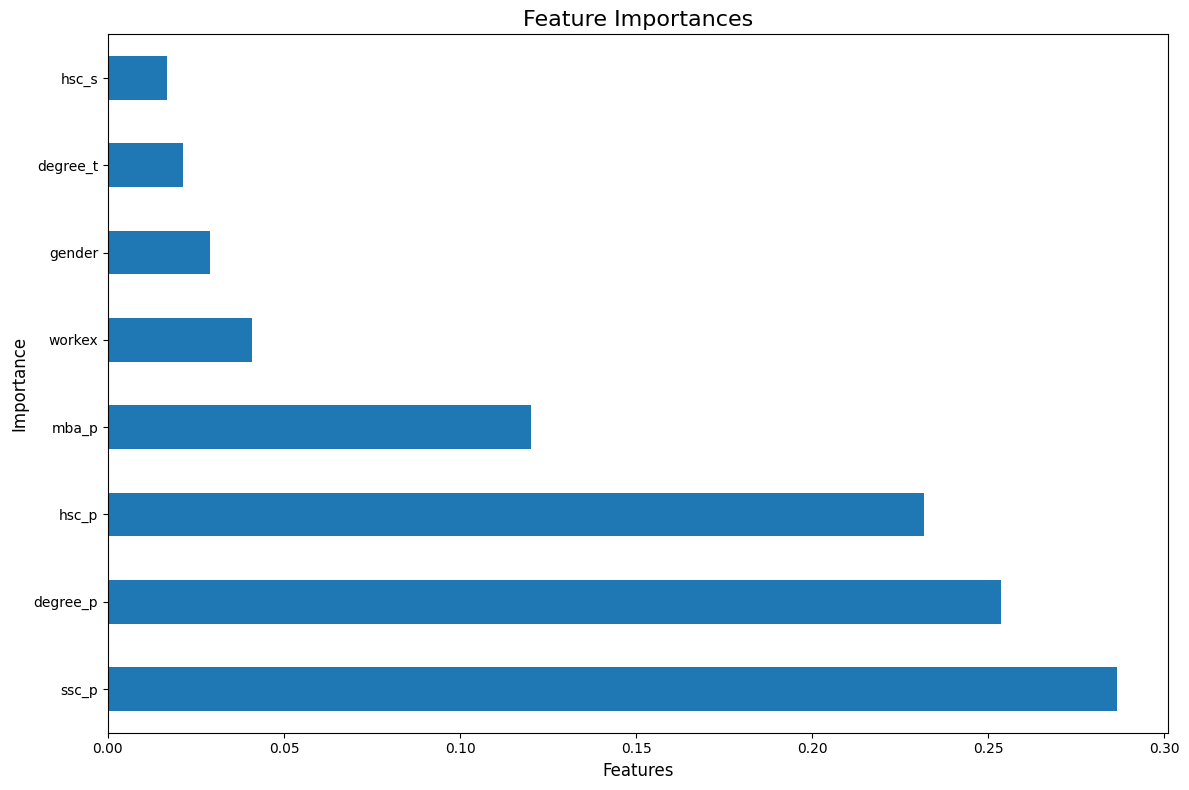

In [65]:
# Feature importance plot (for RandomForest)
if isinstance(best_clf, RandomForestClassifier):
    importances = pd.Series(best_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    importances.plot(kind='barh')
    plt.title('Feature Importances', fontsize=16)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.tight_layout()
    plt.show()

In [66]:
# Save the best model
import joblib
joblib.dump(best_clf, '/content/drive/MyDrive/ML/campus-placement/best_campus_placement_predictor.joblib')

print("Model saved successfully!")

Model saved successfully!
